# Genetic run analysis - StateVector

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from collections import OrderedDict
import pandas as pd

In [22]:
# Loading cross validation data
# First 500 entries: actual CV set
# Last 500 entries: test set that will be used later

# An example set of 100 labeled samples
data_cv, data_labels = np.load("../processed_dataset/data_cv.npy"), np.load("../processed_dataset/data_labels.npy")
nb_features = data_cv.shape[1]

In [23]:
# Classical SVM Benchmarking
# We optimize a Gaussian (RBF) though a grid search (5-folds)

# Define the SVM model with RBF kernel
svm = SVC(kernel='rbf')

# Set up the parameter grid for hyperparameters C and gamma
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 20000, 100000],
    'gamma': [1e-2, 1e-3, 1e-4, 1e-5, 'scale', 'auto']
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, verbose=3, n_jobs=-1)

# Fit the model
grid_search.fit(data_cv, data_labels)

# Print the best parameters and the corresponding score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# Use the best estimator to make predictions
best_svm = grid_search.best_estimator_
predictions = best_svm.predict(data_cv)

avg_accuracy = cross_val_score(
                best_svm,
                data_cv,
                data_labels,
                cv=5,
                scoring="accuracy",
            ).mean()
print("Best classical accuracy (fold average):", avg_accuracy)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters found: {'C': 20000, 'gamma': 0.01}
Best cross-validation score: 0.75
Best classical accuracy (fold average): 0.75


In [26]:
# We load the results from a genetic run
study_type = "2024_12_08 -21_32_36" # other supported: 
suffix = "2024_12_08 -21_32_36"
genes = pd.read_csv("../../Output_genetic/"+study_type+"/genes" +
                 suffix+".csv", header=None, index_col=False).to_numpy()

df_fitnesses = pd.read_csv("../../Output_genetic/"+study_type+"/fitness_values_iter_" +
                 suffix+".csv", header=None, index_col=False).to_numpy().reshape(-1)
accuracies = np.loadtxt("../../Output_genetic/" +
                        study_type+"/accuracy"+suffix+".txt")
sparsities = np.loadtxt("../../Output_genetic/" +
                        study_type+"/sparsity"+suffix+".txt")
stds = np.loadtxt("../../Output_genetic/"+study_type+"/offdiagonal_std_"+suffix+".txt")
gen_id = np.loadtxt("../../Output_genetic/"+study_type+"/generation_id"+suffix+".txt")

# Vary this according to your run input
n_epochs = 100
keep_elitism = 5
pop_size = 30
num_parents_mating = 20

In [27]:
# Helper function that returns the indices related to the best kernels in a generation
def get_champions(previous_gen_fitness, keep_elitism):
    if keep_elitism > 0:
        ascending_order_idx = np.argsort(previous_gen_fitness)
        top_n_indices = ascending_order_idx[-keep_elitism:]
        top_n_indices = top_n_indices[::-1]
        return top_n_indices
    else:
        return None

In [38]:
# Group all data into np.ndarrays (kernel_id_in_generation, nb_generation)
if keep_elitism > 0:
    grouped_fitness = np.zeros((n_epochs+1, pop_size))
    grouped_accuracies = np.zeros((n_epochs+1, pop_size))
    grouped_stds = np.zeros((n_epochs+1, pop_size))

    grouped_fitness[0] = df_fitnesses[:pop_size]
    grouped_accuracies[0] = accuracies[:pop_size]
    grouped_stds[0] = stds[:pop_size]
    for i in range(1, n_epochs+1):
        elite_idxes = get_champions(grouped_fitness[i-1], keep_elitism)
        idx = np.argwhere(gen_id == i)
        grouped_fitness[i, :keep_elitism + len(idx)] = np.concatenate([grouped_fitness[i-1][elite_idxes], df_fitnesses[idx].reshape(-1)])
        grouped_accuracies[i, :keep_elitism + len(idx)] = np.concatenate([grouped_accuracies[i-1][elite_idxes], accuracies[idx].reshape(-1)])
        grouped_stds[i, :keep_elitism + len(idx)] = np.concatenate([grouped_stds[i-1][elite_idxes], stds[idx].reshape(-1)])
else:
    grouped_fitness = np.zeros((n_epochs+1, pop_size - num_parents_mating))
    grouped_accuracies = np.zeros((n_epochs+1, pop_size - num_parents_mating))
    grouped_stds = np.zeros((n_epochs+1, pop_size - num_parents_mating))
    for i in range(1, n_epochs+1):
        idx = np.argwhere(gen_id == i)
        grouped_fitness[i, :len(idx)] = df_fitnesses[idx].reshape(-1)
        grouped_accuracies[i, :len(idx)] = accuracies[idx].reshape(-1)
        grouped_stds[i, :len(idx)] = stds[idx].reshape(-1)

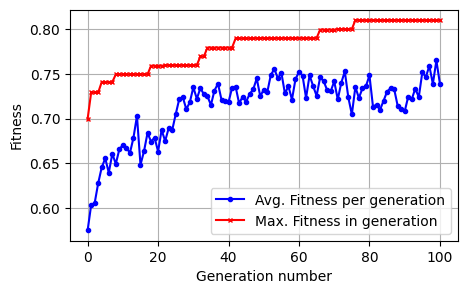

In [39]:
# Fitness function across generations

non_zero_mask = grouped_fitness != 0
# Use the mask to ignore zero entries while computing the mean along axis 1
mean_without_zeros = np.ma.masked_array(grouped_fitness, mask=~non_zero_mask).mean(axis=1)
max_without_zeros = np.ma.masked_array(grouped_fitness, mask=~non_zero_mask).max(axis=1)

# Plotting
plt.figure(figsize=(5, 3))
plt.plot(mean_without_zeros, label='Avg. Fitness per generation', linestyle='-', marker='o', color='b', markersize=3)
plt.plot(max_without_zeros, label='Max. Fitness in generation', linestyle='-', marker='x', color='r', markersize=3)

# Adding labels and title
plt.xlabel('Generation number')
plt.ylabel("Fitness")
# Adding legend
plt.legend()

# Adding grid
plt.grid(True)

# Show plot
plt.show()

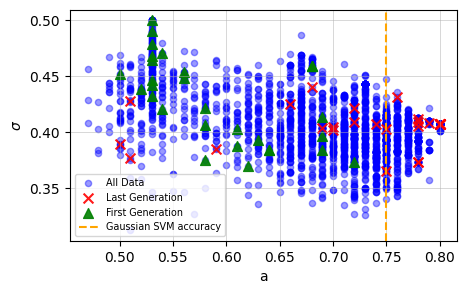

In [40]:
plt.figure(figsize=(5, 3))

# Scatter plot for all accuracies and stds
plt.scatter(accuracies, stds, label='All Data', color='b', marker='o', s=20, alpha=0.4)

# Scatter plot for the last generation
plt.scatter(grouped_accuracies[-1, :], grouped_stds[-1, :], label='Last Generation', color='r', marker='x', s=50, alpha=0.9)

# Scatter plot for the first generation
plt.scatter(grouped_accuracies[1, :], grouped_stds[1, :], label='First Generation', color='g', marker='^', s=50, alpha=0.9)
plt.axvline(x=avg_accuracy, color='orange', linestyle='--', label='Gaussian SVM accuracy')

# Adding labels and title
plt.xlabel('a')
plt.ylabel(r'$\sigma$')

# Adding legend in the lower left
plt.legend(loc='lower left', fontsize='x-small')

# Adding grid
plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.7)

# Show plot
plt.show()

In [41]:
gate_dict = OrderedDict(
    [
        ("single_non_parametric", ["Id", "H", "X", "SX"]),
        ("single_parametric", ["RX", "RY", "RZ"]),
        ("two_non_parametric", ["CX"]),
        ("two_parametric", ["CRX", "CRY", "CRZ"]),
    ]
)

In [42]:
fittest_kernel_id = np.argmax(df_fitnesses)
fittest_kernel_accuracy = accuracies[fittest_kernel_id]
fittest_kernel_sparsity = sparsities[fittest_kernel_id]
fittest_kernel_stds = stds[fittest_kernel_id]
print(f"Best kernel found after {fittest_kernel_id} iterations")
print(f"Best kernel accuracy: {fittest_kernel_accuracy}")
print(f"Best kernel sparsity: {fittest_kernel_sparsity}")
print(f"Best kernel std: {fittest_kernel_stds}")

Best kernel found after 1922 iterations
Best kernel accuracy: 0.8000000000000002
Best kernel sparsity: 0.12023313340868469
Best kernel std: 0.40765991984715744
